In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor, Normalize
from sklearn.model_selection import train_test_split
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import tqdm.notebook as tqdm

plt.style.use('ggplot')

# Part II : Multinominal Softmax Classification

In [2]:
raw_mnist = torchvision.datasets.MNIST("./", download=True)

x_train, x_test = train_test_split(raw_mnist.data, test_size=0.3, random_state=166003)
y_train, y_test = train_test_split(raw_mnist.targets, test_size=0.3, random_state=166003)

x_train = x_train.reshape(-1, 28 * 28).numpy()
x_test = x_test.reshape(-1, 28 * 28).numpy()

# important so softmax wont overflow 
x_train = (x_train - np.min(x_train)) / (np.max(x_train) - np.min(x_train))
x_test = (x_test - np.min(x_test)) / (np.max(x_test) - np.min(x_test))


y_test = y_test.numpy()
y_train = y_train.numpy()

# one hotting labels
# y_test = np.eye(10)[y_test].astype(np.int32)
y_train = np.eye(10)[y_train].astype(np.int32)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


(42000, 784) (18000, 784) (42000, 10) (18000,)


## Gradients 




Feed forward:
$$ z = \hat{y}= \textbf{xw} + \textbf{b} $$

Softmax Activation Function:

$$\sigma (z) = \frac{\text{exp}(z_i)}{\sum_{j=0}^{K}\text{exp}(z_j)}$$
$$\sigma (w) = \frac{\text{exp}(xw_i+b_i)}{\sum_{j=0}^{K}\text{exp}(xw_j+b_j)}$$

Loss Function - CrossEntropy for Binary Classification: 

$$ L(y, \hat{y}) = −log \hspace{2px} p(y|x) = -[y \hspace{2px}log \hspace{2px} \hat{y} \hspace{2px}+\hspace{2px} (1-y)\hspace{2px}log \hspace{2px}(1-\hat{y})]$$

Considering the labels are represented in one-hot fashion, in which each element of $\hat{y}$ represents the probability $ p(\hat{y_k}= 1 |x)$, therefore the multiclass version will be the sum of the logs of the $K$ classes 

$$ L(y, \hat{y}) = -\sum_{i=0}^{K} y_i \hspace{2px}log\hspace{2px}\hat{y_i}  $$ 

Note that, given the one hot encoding all terms that are not the desired class k, will be equal to zero, simplifying the loss to: 

$$ L(y, \hat{y}) = -\hspace{2px}log\hspace{2px}\hat{y_k}  $$

$$ L(w) = -log\hspace{2px} \left(  \frac{\text{exp}(\textbf{xw}_i + \textbf{b}_i )}{\sum_{j=0}^{K}\text{exp}(\textbf{xw}_j + \textbf{b}_j )}\right) $$


$$L(z) = -log\hspace{2px} \left(  \frac{e^{z_i}} {\sum_{j=0}^{K}e^{z_j}} \right) $$

By applying the log division rule, this will be helpfull to avoid using the derivative quotient rule :

$$L(z) = -\left( z_i -log\sum_{j=0}^{K}e^{z_j}  \right)$$

Now computing the derivative in respect to the class $i$ :

$$ \frac{\partial L}{\partial z_i} = -\frac{\partial }{\partial z_i} \left( z_i -log\sum_{j=0}^{K}e^{z_j}  \right) $$

$$\frac{\partial L}{\partial z_i} = -\frac{\partial }{\partial z_i} z_i + \frac{\partial }{\partial z_i}log\sum_{j=0}^{K}e^{z_j}   $$

$$\frac{\partial L}{\partial z_i} = -1 + log\sum_{j=0}^{K}\frac{\partial }{\partial z_i}e^{z_j} $$

Note that the derivative for all the possibilities except for the desired class, its zero, therefore:

$$ \frac{\partial }{\partial z_i}e^{z_j} = \left\{ \begin{array}{cl}
0 & : \ z_j \neq z_i \\
e^{z_i} & : \ z_j  = z_i
\end{array} \right. $$

$$ \frac{\partial }{\partial z_i}log\left( \sum_{j=0}^{K}e^{z_j} \right) = \frac{1}{\sum_{j=0}^{K}e^{z_j} } e^{z_i} 
 $$

$$\frac{\partial L}{\partial z_i} = 1 - \frac{1}{\sum_{j=0}^{K}e^{z_j} } e^{z_i} = 1 - z_i$$


Now applying the chain rule: 

$$  \frac{\partial L}{\partial w_i} = \frac{\partial L}{\partial z_i} \frac{\partial z_i}{\partial w_i}     $$

$$  \frac{\partial L}{\partial b_i} = \frac{\partial L}{\partial z_i} \frac{\partial z_i}{\partial b_i}     $$

$$ \frac{\partial L}{\partial w_i} =  -\left( 1 -  z_i \right) \textbf{x}  =  -\left( 1 - \frac{\text{exp}(\textbf{xw}_i + \textbf{b}_i )}{\sum_{j=0}^{K}\text{exp}(\textbf{xw}_j + \textbf{b}_j )}\right)\textbf{x}$$ 

$$ \frac{\partial L}{\partial b_i} =  \left( 1 -  z_i \right)  =  \left( 1 - \frac{\text{exp}(\textbf{xw}_i + \textbf{b}_i )}{\sum_{j=0}^{K}\text{exp}(\textbf{xw}_j + \textbf{b}_j )}\right)$$ 

## Handmade Softmax Regression

In [3]:
class SoftmaxRegression():
    def __init__(self, p_size, n_classes, lr=0.001):
        # self.w = np.random.rand(p_size, n_classes) * 0.01
        self.w = np.random.rand(n_classes, p_size) * 0.01
        self.b = np.random.rand(n_classes)
        self.v_w = np.zeros_like(self.w)
        self.v_b = np.zeros_like(self.b)

    def get_parameters(self):
        return self.w.reshape(-1, 28*28), self.b

    def forward(self, X):
        return ( X @ self.w.T ) + self.b 

    def compute_probs(self, logits):
        # softmax the network outputs
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))  # keep stability 
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    def crossEntropy(self, y_hat, y):
        b = - y * np.log(y_hat)
        return b.sum(axis=-1) / len(y)

    def loss_derivative(self, x, y_hat, y):
        return -(y - y_hat).T @ x / len(x), -np.sum(y - y_hat, axis=0) / len(x)

    
    def gradient_descent(self, w_gradient, b_gradient, lr):
        
        self.w -= self.lr * w_gradient
        self.b -= self.lr * b_gradient

    def stochastic_gradient_descent(self, X, y, lr):
        
        random_indexes = np.arange(len(X))
        np.random.shuffle(random_indexes)

        X = X[random_indexes]
        y = y[random_indexes]
        
        logits = self.forward(X)
        y_hat = self.compute_probs(logits)
        ce_loss = self.crossEntropy(y_hat, y)
        w_gradient, b_gradient = self.loss_derivative(X, y_hat) 

        self.w -= self.lr * w_gradient.T
        self.b -= self.lr * b_gradient.T

        return ce_loss

    def momentum_sgd(self, X, y, lr, beta=0.9):
        
        random_indexes = np.arange(len(X))
        np.random.shuffle(random_indexes)

        X = X[random_indexes]
        y = y[random_indexes]
        
        logits = self.forward(X)
        y_hat = self.compute_probs(logits)
        ce_loss = self.crossEntropy(y_hat, y)
        w_gradient, b_gradient = self.loss_derivative(X, y_hat) 

        self.v_w = self.v_w * beta - self.lr * w_gradient.T
        self.v_b = self.v_b * beta - self.lr * b_gradient.T

        self.w -= self.v_w
        self.b -= self.v_b 

        return ce_loss
    
def optimize_model(model, opt_strategy, lr, epochs, traindata, testdata):

    x_train, y_train = traindata
    x_test, y_test = testdata
    loss_hist, acc_hist = [], []

    opt_foo = model.gradient_descent        
    if opt_strategy == "GD":
        opt_foo = model.gradient_descent
    elif opt_strategy == "SGD":
        opt_foo = model.stochastic_gradient_descent
    elif opt_strategy == "M-SGD":
        opt_foo = model.momentum_sgd

    for e in range(epochs):

        logits = model.forward(x_train)
        y_hat = model.compute_probs(logits)
        ce_loss = model.crossEntropy(y_hat, y_train)
        w_gradient, b_gradient = model.loss_derivative(x_train, y_hat, y_train) 
        opt_foo(w_gradient, b_gradient, lr=lr)
        preds = np.argmax(model.compute_probs(model.forward(x_test)), axis=1)
        acc = accuracy_score(y_test, preds)
        loss = ce_loss.sum()
        
        loss_hist.append(loss)
        acc_hist.append(acc)

    return np.array(acc), np.array(loss)




## Pytorch Softmax Regression

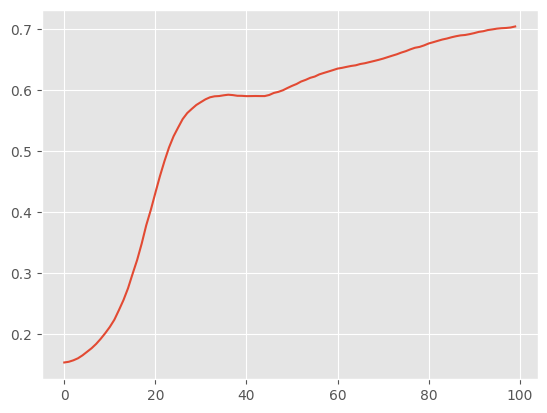

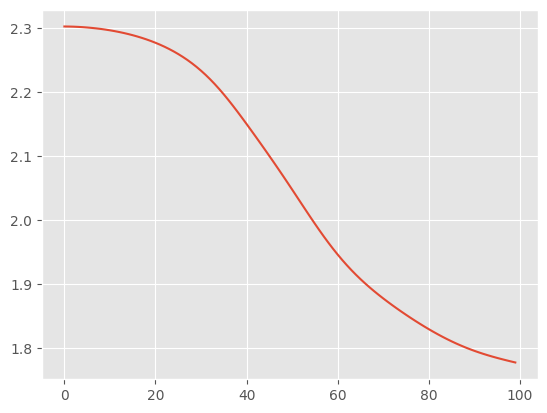

In [4]:
class PytorchSoftmaxRegression(nn.Module):

    def __init__(self, size, n_classes):
        super(PytorchSoftmaxRegression, self ).__init__()
        self.layer = nn.Linear(size, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        logits = self.layer(x)
        return self.softmax(logits)
    
    
    def optimize(self, epochs, opt, loss_f, traindata, testdata):

        x_train, y_train = traindata
        x_test, y_test = testdata
        loss_hist, acc_hist = [], []
        
        for e in range(epochs):
            y_hat = self.forward(x_train)
            loss = loss_f(y_hat, y_train)
            preds = self.forward(x_test).argmax(dim=1)          
            acc = accuracy_score(y_test, preds)
            loss_hist.append(loss.item())
            acc_hist.append(acc)
            loss.backward()
            opt.step()



        return np.array(acc_hist), np.array(loss_hist)


lr = 0.01

pytorch_model = PytorchSoftmaxRegression(784, 10)
opt = torch.optim.SGD(pytorch_model.parameters(), lr=lr)
loss_foo = nn.CrossEntropyLoss()

traindata = (torch.from_numpy(x_train.astype(np.float32)), torch.from_numpy(y_train.astype(np.float32)))
testdata = (torch.from_numpy(x_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32)))

acc, loss = pytorch_model.optimize(100, opt, loss_foo, traindata, testdata)

plt.plot(acc)
plt.show()
plt.plot(loss)